# Introduction

We are data analysts employeed by the NCAA. We were given the assigment to study the given dataset to find any noticeable trends that should be researched further. We are going to focus on the Academic Progress Rate (APR), which is a calculation based off how many athletes on a team remain academiclly elligible and with the university. Most of the data within the NCAA dataset is not gathered by the NCAA. In fact, almost all of it is gathered by the member schools, and then shared with the NCAA. However, some of this data has been directly gathered by the NCAA. The dataset can be found at this link https://www.ncaa.org/sports/2016/12/14/shared-ncaa-research-data.aspx. We will be attempting to answer the following four questions:

1. How have the retention rates for NCAA schools changed over the available data, from 2004 to 2019? We will be using all of the RET_Rate_XXXX columns where XXXX represents a different year for each column

2. What variables are the most positively correlated with multi-year APR, and can we accurately predict what a teams multi-year APR will be given other data? (regression). This will involve using linear regression on the whole dataset to determine which variables are significant.

3. Do Private or Public schools have better APR and academic eligibility rates? We will be using the multi-year APR and multi-year academic eligibility columns and SCL_PRIVATE column.

4. Exploratory analysis: How many sports are fielded by each institution, and does that vary between NCAA divisions?  We will be using the SCL_UNITID and SCL_NAME columns as well as the Sport_Code and Sport_Name to analyse the counts of sports by each university. This is important to see if schools generally field the same number of sports or if there's drastic differences between schools and analyze what could be different from schools with a high number of sports and those with a low number.

To start with though, we need to clean the dataset.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

In [50]:
raw_data = pd.read_csv('C:/Users/natha/OneDrive/Documents/GitHub/DIDA_325_Final-project/csvs/raw data.csv')
drops=[0,12,20,85]
raw_data.drop(raw_data.columns[drops], axis=1, inplace=True)


 #The columns we want to fill are the 83rd to 98th columns (0-indexed) so we are creating a list of their indices using the range function
cols_to_fill = list(range(82, 97)) 
raw_data.iloc[:, cols_to_fill] = raw_data.iloc[:, cols_to_fill].fillna(0)

null_counts = raw_data.isnull().sum()
null_counts = null_counts[null_counts > 0]

print(null_counts.sort_values(ascending=False))

D1_FB_CONF_19                     1578
ELIG_RATE_2004                     900
APR_RATE_2004_1000                 900
NUM_OF_ATHLETES_2004               900
RET_RATE_2004                      900
                                  ... 
MULTIYR_ELIG_RATE                   15
MULTIYR_APR_RATE_1000_CI            15
MULTIYR_APR_RATE_1000_RAW           15
MULTIYR_SQUAD_SIZE                  15
MULTIYR_APR_RATE_1000_OFFICIAL      15
Length: 71, dtype: int64


Columns at index 0,12,20, and 85 were completley empty, so we will drop those columns. Next, columns at index 82 to 97 are littered with empty values, according to the documentation empty values there should actually be zeros so we use the fillna function so any empty values are replaced with zeros. Finnally, we print which columns have null values, and how many null values they have, doing so allows us to make more informed descions on how to clean the rest of the dataset.

In [51]:

raw_data.drop(columns=['D1_FB_CONF_19'], inplace=True)
# we use the subset paramter to specify which columns we want to check for null values and drop the rows with null values in those columns. https://www.w3schools.com/python/pandas/ref_df_dropna.asp
clean_data=raw_data.dropna(subset=['MULTIYR_RET_RATE', 'MULTIYR_APR_RATE_1000_RAW', 'MULTIYR_APR_RATE_1000_CI', 'MULTIYR_APR_RATE_1000_OFFICIAL', 'MULTIYR_SQUAD_SIZE', 'MULTIYR_ELIG_RATE'])

The "D1_FB_CONF_19" column has a lot of empty values, and is very similar to the "CONFNAME" column, so we will drop the column as a whole. Lastly, any rows that have null values in any of the multi year statistics will be useless for us, so we can drop all of those rows.

The columns remaining are SCL_UNITID (int) which is the id for each column, SCL_NAME (character), the name for the university, Sport_Code (Cateogry) and Sport_Name (chategory) which represent the id and name of the respective sport, Academic_Year(category) the year for that row, SCL_DIV_19 (Category), and SCL_SUB_19 (Category) which represent the NCAA division and subdivision they play in. CONFNAME (character) is the schools conference they compete in. SL_HBCU (category) and SL_Private (category) which is a binary data that shows if a school is HBCU and if a school is private. Then there are MULTIYR_APR_RATE_1000_RAW, MULTIYR_APR_RATE_1000_CI, MULTIYR_APR_RATE_1000_OFFICIAL, MULTIYR_SQUAD_SIZE, MULTIYR_ELIG_RATE,MULTIYR_RET_RATE which are all numeric and represent multiyear academic stats. Then from each year from 2006-2019 there are APR_RATE_XXXX_1000, ELIG_RATE_XXXX, RET_RATE_XXX, NUM_OF_ATHLETES_XXXX which are all numeric and represent single year academic stats. There are a lot of each column these are which each category of column means

APR_Rate: Academic Progress Rate as calculated by the NCAA.

ELIG_RATE: Percentage of athletes on a team which are academically elligible to compete.

RET_RATE: Percenentage of athletes who remain on the team after a year (excluding gratuating seniors and transfers)

NUM_OF_ATHLETES/MULTIYR_SQUAD_SIZE: The number of athletes on a sports teams roster.

Finally from 2006-2020 there are PUB_AWARD_XX which are categorical values that display if a school got an academic award from the NCAA.

In [52]:
# This leaves us with the following dataset
clean_data.head()

,SCL_UNITID,SCL_NAME,SPORT_CODE,SPORT_NAME,ACADEMIC_YEAR,SCL_DIV_19,SCL_SUB_19,CONFNAME_19,SCL_HBCU,SCL_PRIVATE,...,PUB_AWARD_15,PUB_AWARD_14,PUB_AWARD_13,PUB_AWARD_12,PUB_AWARD_11,PUB_AWARD_10,PUB_AWARD_09,PUB_AWARD_08,PUB_AWARD_07,PUB_AWARD_06
0,100654,Alabama A&M University,1,Baseball,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100654,Alabama A&M University,2,Men's Basketball,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100654,Alabama A&M University,4,Football,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100654,Alabama A&M University,6,Men's Golf,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100654,Alabama A&M University,13,Men's Tennis,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# Data Analaysis

# Question 1:

 How have the Retention Rates of NCAA Member Schools changed between 2004 and 2019? We will be using all of the RET_Rate_XXXX columns where XXXX represents a different year for each column. This is an important question to answer because if there is a trend in either the positive or negative direction, it is imperative that the NCAA is able to identify it. A decrease in retention rate would signify that academics for athletes across all of division one are decreasing and there needs to be a drastic change. An increase in retention rate will show that member instiutions are improving their focus on academics. Going into the question are assumption is there will not be a noticeable trend.

In [53]:
data=clean_data.copy()
#removing unnesecary columns
data_ret=data.drop(columns=[ 'MULTIYR_APR_RATE_1000_RAW', 'MULTIYR_APR_RATE_1000_CI',
       'MULTIYR_APR_RATE_1000_OFFICIAL', 'RAW_OR_CI', 'MULTIYR_SQUAD_SIZE',
       'MULTIYR_ELIG_RATE', 'MULTIYR_RET_RATE', 'APR_RATE_2019_1000',
       'ELIG_RATE_2019', 'NUM_OF_ATHLETES_2019',
       'APR_RATE_2018_1000', 'ELIG_RATE_2018',
       'NUM_OF_ATHLETES_2018', 'APR_RATE_2017_1000', 'ELIG_RATE_2017', 'NUM_OF_ATHLETES_2017', 'APR_RATE_2016_1000',
       'ELIG_RATE_2016', 'NUM_OF_ATHLETES_2016',
       'APR_RATE_2015_1000', 'ELIG_RATE_2015',
       'NUM_OF_ATHLETES_2015', 'APR_RATE_2014_1000', 'ELIG_RATE_2014',
        'NUM_OF_ATHLETES_2014', 'APR_RATE_2013_1000',
       'ELIG_RATE_2013', 'NUM_OF_ATHLETES_2013',
       'APR_RATE_2012_1000', 'ELIG_RATE_2012',
       'NUM_OF_ATHLETES_2012', 'APR_RATE_2011_1000', 'ELIG_RATE_2011',
       'NUM_OF_ATHLETES_2011', 'APR_RATE_2010_1000',
         'NUM_OF_ATHLETES_2010','ELIG_RATE_2010',
       'APR_RATE_2009_1000', 'ELIG_RATE_2009',
       'NUM_OF_ATHLETES_2009', 'APR_RATE_2008_1000', 'ELIG_RATE_2008',
       'NUM_OF_ATHLETES_2008', 'APR_RATE_2007_1000',
       'ELIG_RATE_2007', 'NUM_OF_ATHLETES_2007',
       'APR_RATE_2006_1000', 'ELIG_RATE_2006',
       'NUM_OF_ATHLETES_2006', 'APR_RATE_2005_1000', 'ELIG_RATE_2005',
       'NUM_OF_ATHLETES_2005', 'APR_RATE_2004_1000',
       'ELIG_RATE_2004',  'NUM_OF_ATHLETES_2004',
       'PUB_AWARD_20', 'PUB_AWARD_19', 'PUB_AWARD_18', 'PUB_AWARD_17',
       'PUB_AWARD_16', 'PUB_AWARD_15', 'PUB_AWARD_14', 'PUB_AWARD_13',
       'PUB_AWARD_12', 'PUB_AWARD_11', 'PUB_AWARD_10', 'PUB_AWARD_09',
       'PUB_AWARD_08', 'PUB_AWARD_07', 'PUB_AWARD_06','SCL_UNITID', 'SCL_NAME', 'SPORT_CODE', 'SPORT_NAME', 'ACADEMIC_YEAR',
       'SCL_DIV_19', 'SCL_SUB_19', 'CONFNAME_19', 'SCL_HBCU', 'SCL_PRIVATE'])

In [54]:
data_ret[['RET_RATE_2019', 'RET_RATE_2018', 'RET_RATE_2017', 'RET_RATE_2016',
       'RET_RATE_2015', 'RET_RATE_2014', 'RET_RATE_2013', 'RET_RATE_2012',
       'RET_RATE_2011', 'RET_RATE_2010', 'RET_RATE_2009', 'RET_RATE_2008',
       'RET_RATE_2007', 'RET_RATE_2006', 'RET_RATE_2005', 'RET_RATE_2004']].apply({"RET_RATE_2019":["mean","median","min","max"],
                                        "RET_RATE_2018":["mean","median","min","max"],
                                        "RET_RATE_2017":["mean","median","min","max"],

                                        "RET_RATE_2016":["mean","median","min","max"],
                                        "RET_RATE_2015":["mean","median","min","max"],
                                        "RET_RATE_2014":["mean","median","min","max"],
                                        "RET_RATE_2013":["mean","median","min","max"],
                                        "RET_RATE_2012":["mean","median","min","max"],
                                        "RET_RATE_2011":["mean","median","min","max"],
                                        "RET_RATE_2010":["mean","median","min","max"],
                                        "RET_RATE_2009":["mean","median","min","max"],
                                        "RET_RATE_2008":["mean","median","min","max"],
                                         "RET_RATE_2007":["mean","median","min","max"],
                                         "RET_RATE_2006":["mean","median","min","max"],
                                         "RET_RATE_2005":["mean","median","min","max"],
                                         "RET_RATE_2004":["mean","median","min","max"]})

,RET_RATE_2019,RET_RATE_2018,RET_RATE_2017,RET_RATE_2016,RET_RATE_2015,RET_RATE_2014,RET_RATE_2013,RET_RATE_2012,RET_RATE_2011,RET_RATE_2010,RET_RATE_2009,RET_RATE_2008,RET_RATE_2007,RET_RATE_2006,RET_RATE_2005,RET_RATE_2004
mean,0.977916,0.977561,0.977910,0.977246,0.975696,0.975297,0.973303,0.970338,0.969084,0.967932,0.967932,0.965953,0.955539,0.953580,0.952880,0.952737
median,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.983471,0.980769,0.980392,0.980066,0.977778,0.965517,0.962963,0.962963,0.962963
min,0.571429,0.555556,0.727273,0.444444,0.666667,0.636364,0.714286,0.666667,0.680000,0.666667,0.555556,0.684211,0.571429,0.631579,0.571429,0.611111
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:
data_ret.mean()

RET_RATE_2019    0.977916
RET_RATE_2018    0.977561
RET_RATE_2017    0.977910
RET_RATE_2016    0.977246
RET_RATE_2015    0.975696
RET_RATE_2014    0.975297
RET_RATE_2013    0.973303
RET_RATE_2012    0.970338
RET_RATE_2011    0.969084
RET_RATE_2010    0.967932
RET_RATE_2009    0.967932
RET_RATE_2008    0.965953
RET_RATE_2007    0.955539
RET_RATE_2006    0.953580
RET_RATE_2005    0.952880
RET_RATE_2004    0.952737
dtype: float64

From examining the means of yearly retention rates, spanning 2004 to 2019, we are able to see a trend of retention rates improving year over year. This indicates that as a whole, NCAA member schools are improving their rentention, and therefore improving as schools. While this change is small, it still implies that the quality of education in member schools is increasing, causing more students to stay.

Visual Representation

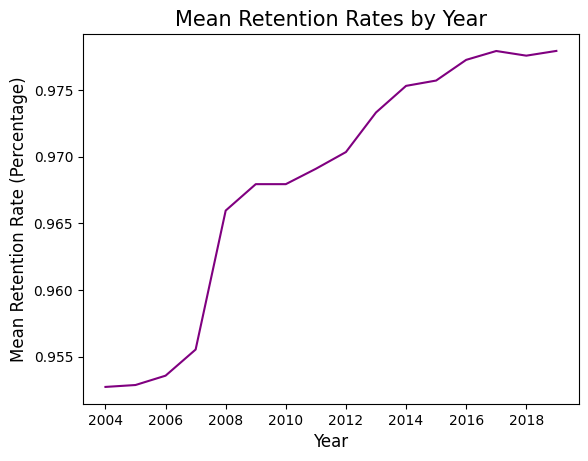

In [56]:
#This stores the means for each year's retention rates, associated with the correct year for the purposes of data visualization
meanslist = {'year': [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019], 're_mean': [0.952737,0.952880,0.953580,0.955539,0.965953,0.967932,0.967932,0.969084,0.970338,0.973303,0.975297,0.975696,0.977246,0.977910,0.977561,0.977916]}
meansframe = pd.DataFrame(meanslist)

sns.lineplot(meansframe, x='year', y='re_mean', color='purple')
plt.title("Mean Retention Rates by Year", fontsize=15)
plt.ylabel("Mean Retention Rate (Percentage)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.show()

From this graph it can be confirmed that retention rates appear to be increasing year over year in NCAA member schools.

Conclusion:

From the retention rates alone, it would appear that the quality of NCAA member schools is increasing. Retention rate means have increased year over year, with no recorded drops between 2004 and 2019. A higher mean retention rate indcates that overall, more students are staying at their schools. The NCAA board can use this data to confirm beliefs that methods they are using to increase retention rates are in fact working.

# Question 2:

 What variables are the most positively correlated with multi-year APR, and can we accurately predict what a teams multi-year APR will be given other data? (regression). This will involve using linear regression on the whole dataset to determine which variables are significant.

There are a couple of reasons why this is an important question to answer. One being that if the NCAA can predict what teams will have a higher or lower APR it knows which schools and sports it can provide athletes with more resources to help the students. Additionally if the NCAA knows which factors are most important for predicting APR they can know exactly how to help their athletes. Before answering the question I do beleive we'll be able to train a linear regression model that does a strong job at predicting APR, additionally I beleive multi year retention rates and multi year eligibility rates will be the two strongest variables in prediciting APR.


In [57]:
# Creating a copy of the dataset to work with this specific research qeustion
data=clean_data.copy()
x_columns=['SCL_HBCU', 'SCL_PRIVATE', 'MULTIYR_SQUAD_SIZE', 'SCL_SUB_19', 'MULTIYR_ELIG_RATE', 'MULTIYR_RET_RATE'] 
X=data[x_columns] 
X = pd.get_dummies(X, drop_first=True).astype("float32") #
y=data['MULTIYR_APR_RATE_1000_OFFICIAL'] 
X = sm.tools.tools.add_constant(X) 
model=sm.OLS(y, X).fit() 
print(model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     MULTIYR_APR_RATE_1000_OFFICIAL   R-squared:                       0.896
Model:                                        OLS   Adj. R-squared:                  0.896
Method:                             Least Squares   F-statistic:                     8643.
Date:                            Wed, 14 May 2025   Prob (F-statistic):               0.00
Time:                                    21:23:28   Log-Likelihood:                -18418.
No. Observations:                            6002   AIC:                         3.685e+04
Df Residuals:                                5995   BIC:                         3.690e+04
Df Model:                                       6                                         
Covariance Type:                        nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---

From the model summary we can see that "MULTIYR_SQUAD_SIZE", "MULTIYR_ELIG_RATE", "MULTIYR_RET_RATE", and "SCL_HCBU_Y" are all signifiicant variables as their p-values round to zero and using the coefficients we can gleam the following

MULTIYR_SQUAD_SIZE:
Every additional 1 person added to the squad size decreases the APR score by 0.0156 points, on average, holding other variables constant.

MULTIYR_ELIG_RATE:
Every 1.0 (or 100 percentage points) increase in eligibility rate would increase APR by 424.32 points. More realistically, a 1% increase (i.e., +0.01) in eligibility rate would increase APR by about 4.24 points.

MULTIYR_RET_RAT:
Every 1.0 (or 100 percentage points) increase in retention rate would increase APR by 420.22 points. So a 1% increase (i.e., +0.01) in retention rate would increase APR by about 4.20 points.

SCL_HBCU_Y:
If a school is an HBCU (coded as 1), then the APR is higher by about 1.92 points compared to non-HBCUs (coded as 0), holding everything else constant.

Additiionally with an R^2 of about 0.896 we can say that 89.6% of the variance of APR can be explained by SCL_HBCU', 'SCL_PRIVATE', 'MULTIYR_SQUAD_SIZE', 'SCL_SUB_19', 'MULTIYR_ELIG_RATE',  and 'MULTIYR_RET_RATE'. With the model we can predict APR scores decently accurately, compared to simply guessing the mean APR, and about 90% of those prediction improvement come from these six variables.

C:\Users\natha\AppData\Local\Temp\ipykernel_23632\1241326407.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x=yhat, y=residuals, palette='magma')


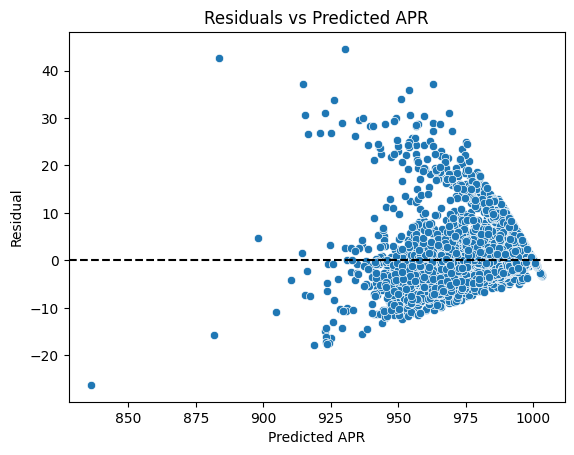

In [58]:
yhat = model.predict()
residuals = y - yhat
ax = sns.scatterplot(x=yhat, y=residuals, palette='magma')
ax.axhline(y=0, color='black', linestyle='dashed')

plt.xlabel("Predicted APR")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted APR")
plt.show()

There do not seem to be any trends with the residuals, which is a good thing for our model as it shows that our regression model is working and linear.

Additionally we could train a machine learning model, to predict a schools APR, which might be more accurate. We will use a random forest regression model, we will be using the same predictor and response variables as in our linear regression model.

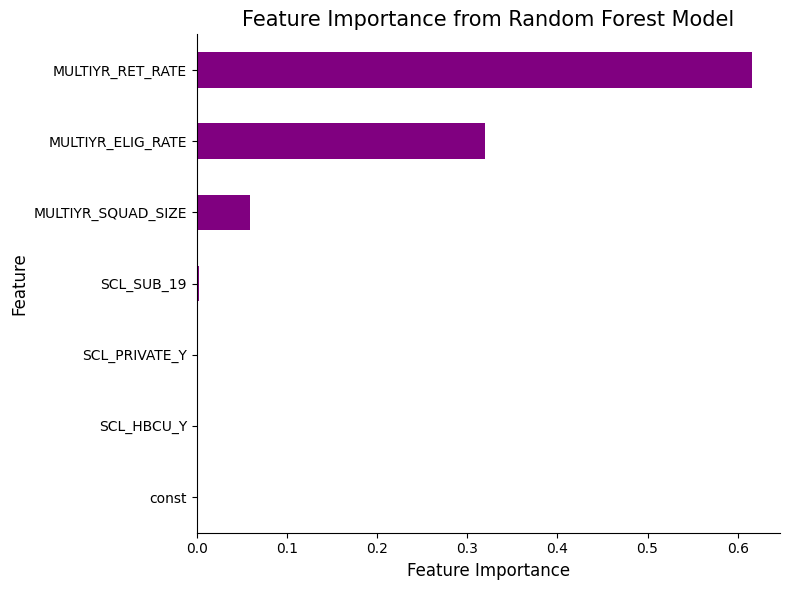

In [59]:
feature_names = X.columns.tolist()
#Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=159)
rf_model = RandomForestRegressor().fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini Importance': importances
})
feature_imp_df = feature_imp_df.sort_values('Gini Importance', ascending=False)
forest_importances = pd.Series(rf_model.feature_importances_,index=feature_names)
forest_importances.sort_values(inplace=True, ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
forest_importances.plot.barh(ax=ax, color='purple')
ax.set_xlabel("Feature Importance")

# Formatting the plot
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title("Feature Importance from Random Forest Model", fontsize=15)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)

fig.tight_layout()

This gives us slightly different results, as in this model the multi year retentionm rate is far and away the most important factor, while eligibility rate and squad size are also important. But the random forest model does not think that wether a school is an HBCU or not is an important factor to predicting a schools APR. But do these differences result in a better model?

In [60]:
predictions = rf_model.predict(X)

# We will use the mean squared error and r-squared metrics to evaluate the model's performance
mse = mean_squared_error(y, predictions)
r2 = r2_score(y,predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 4.949485555215437
R-squared: 0.9810725697204026


C:\Users\natha\AppData\Local\Temp\ipykernel_23632\1703850679.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(x=rf_yhat, y=rf_residuals, palette='magna')


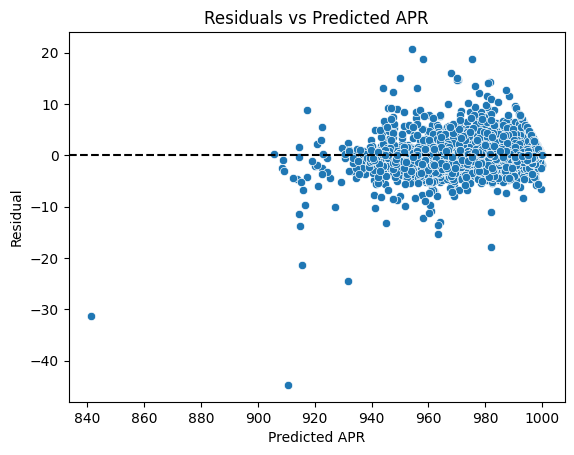

In [61]:
rf_yhat = rf_model.predict(X)
rf_residuals = y - rf_yhat
ax = sns.scatterplot(x=rf_yhat, y=rf_residuals, palette='magna')
ax.axhline(y=0, color='black', linestyle='dashed')

# We will next create a scatterplot of the residuals vs the predicted values to see if there is any pattern in the residuals.
plt.xlabel("Predicted APR")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted APR")
plt.show()

The Mean Squared Error means the average squared difference for each prediction is off by about five APR points, and an R-squared model of 0.98 is even higher than the linear regression model. Meaning that if the NCAA wants to most accuratley predict APR they should use a Random Forest model. Additionally there is no trend in the residual plot and they are highly focused around zero.

Question Conclusion

Based off of the high R squared value it is possible to use both a linear regression model and a random forest model to accurately predict APR rates, but the random forest model is more accurate. We accurately predicted that high retention rates and high eligibility rates would be significant variables, and strongly positvely correlated with higher APR rates. However, we underestimated just how significant the size of a team would be on predicting APR. The NCAA could then use this data to know what schools to funnel resources to and help their athletes. Based on our findings it woud also know to focus on retention rates and eligibility rates to improve APR, in addition to giving an increased help to schools with large roster size. Additionally our models conflict on the importance of a school being HBCU or not so the NCAA should conduct further research on the significance of that factor.

# Question 3
Do Private or Public schools have better APR and academic eligibility rates? We will be using the multi-year APR and multi-year academic eligibility columns and SCL_PRIVATE column. This is important for the NCAA to know because if there's a distinct difference between how private and public school athletes preform academically it can allocate resources appropriatley to help which ever is struggling more. Going into the research we beleive that private schools will preform better as they tend to have more resources.


C:\Users\natha\AppData\Local\Temp\ipykernel_23632\913256964.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


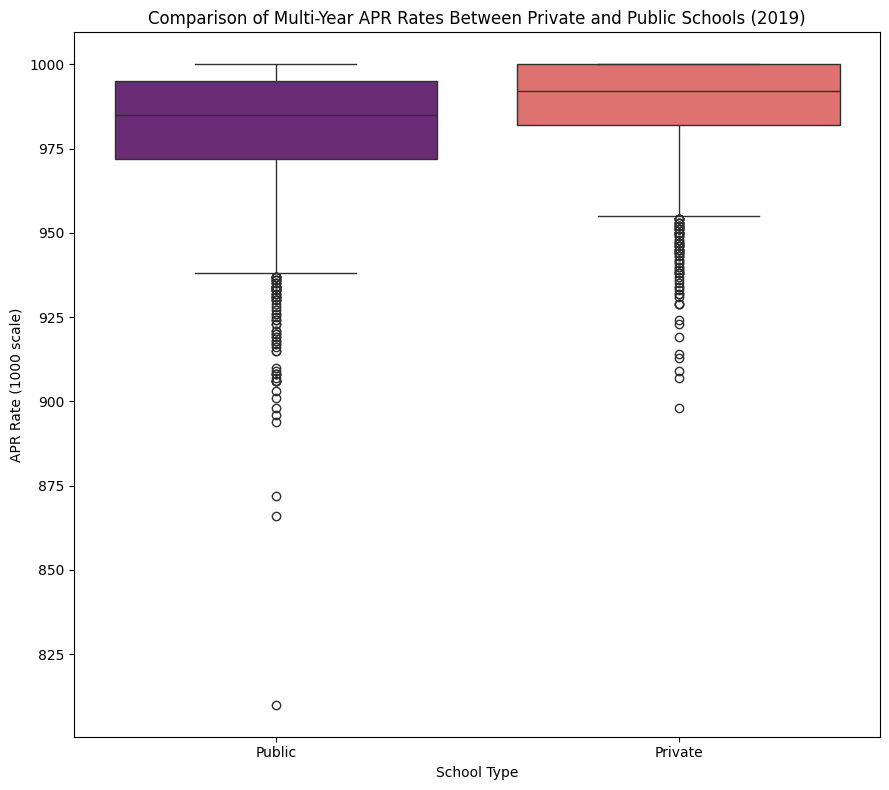

In [62]:
data=clean_data.copy()
data_filtered = data[['SCL_PRIVATE', 'MULTIYR_APR_RATE_1000_RAW', 'ACADEMIC_YEAR']].copy()

data_filtered['School Type'] = data_filtered['SCL_PRIVATE'].map({'Y': 'Private', 'N': 'Public'})

compareSchoolType = data_filtered[data_filtered["ACADEMIC_YEAR"] == 2019].copy()

plt.figure(figsize=(9, 8))

sns.boxplot(
    data=compareSchoolType,
    x="School Type",
    y="MULTIYR_APR_RATE_1000_RAW",
    palette="magma"
)

plt.title('Comparison of Multi-Year APR Rates Between Private and Public Schools (2019)')
plt.ylabel('APR Rate (1000 scale)')
plt.xlabel('School Type')
plt.tight_layout()
plt.show()

C:\Users\natha\AppData\Local\Temp\ipykernel_23632\4102945881.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


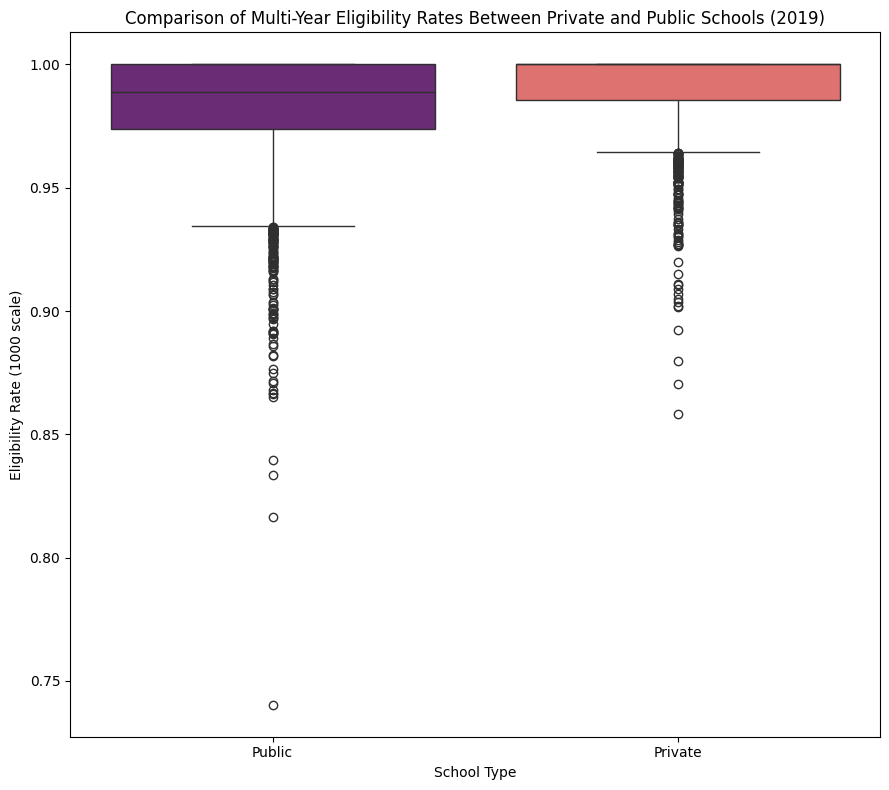

In [63]:
data_filtered = data[['SCL_PRIVATE', 'MULTIYR_ELIG_RATE', 'ACADEMIC_YEAR']].copy()

data_filtered['School Type'] = data_filtered['SCL_PRIVATE'].map({'Y': 'Private', 'N': 'Public'})

compareSchoolType = data_filtered[data_filtered["ACADEMIC_YEAR"] == 2019].copy()

plt.figure(figsize=(9, 8))

sns.boxplot(
    data=compareSchoolType,
    x="School Type",
    y="MULTIYR_ELIG_RATE",
    palette="magma"
)

plt.title('Comparison of Multi-Year Eligibility Rates Between Private and Public Schools (2019)')
plt.ylabel('Eligibility Rate (1000 scale)')
plt.xlabel('School Type')
plt.tight_layout()
plt.show()

Conclusion

From the data we can indeed see that private schools genreally have a better APR, with a median slighly higher then that of public schools. So we were correct on that front, although the difference is not very large or noticeable. Which is noticeable, however, is the large gap in ranges for both APR and eligibility rates. Public schools 25th percentile is significantly lower then that of private schools. Additionally, public schools have much more extreme low end outliers. Based off this data the best course of action for the NCAA would to further analyze what is causing public scools to have these lower outliers, and also to allocate more funding to public schools with limited resources.

# Question 4

How many sports are fielded by each institution, and does that vary between conferences?

We will be using the SCL_UNITID and SCL_NAME columns, the 'CONF_NAME2019' to measure conference, as well as the Sport_Code and Sport_Name to analyse the counts of sports by each university. This is important to see if schools generally field the same number of sports or if there's drastic differences between schools and analyze what could be different from schools with a high number of sports and those with a low number. We expect conferences with bigger schools such as the Big Ten and SEC will have the most sports, and also that the distributuion will vary heavily across conferences.

In [68]:
df = clean_data.copy()
df.head()

##Checking for missing values in our focus columns

df[['SCL_UNITID', 'SCL_NAME', 'SPORT_CODE', 'SPORT_NAME']].isna().sum() #No na's so no need to dropna


#Creating Total sum of sports per school, including division for later
sports_per_school = df.groupby(['SCL_UNITID', 'SCL_NAME', 'CONFNAME_19'])['SPORT_CODE'].nunique().reset_index()
sports_per_school.rename(columns={'SPORT_CODE': 'NUM_SPORTS'}, inplace=True)
sports_per_school
df

,SCL_UNITID,SCL_NAME,SPORT_CODE,SPORT_NAME,ACADEMIC_YEAR,SCL_DIV_19,SCL_SUB_19,CONFNAME_19,SCL_HBCU,SCL_PRIVATE,...,PUB_AWARD_15,PUB_AWARD_14,PUB_AWARD_13,PUB_AWARD_12,PUB_AWARD_11,PUB_AWARD_10,PUB_AWARD_09,PUB_AWARD_08,PUB_AWARD_07,PUB_AWARD_06
0,100654,Alabama A&M University,1,Baseball,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100654,Alabama A&M University,2,Men's Basketball,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100654,Alabama A&M University,4,Football,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100654,Alabama A&M University,6,Men's Golf,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100654,Alabama A&M University,13,Men's Tennis,2019,1,2,Southwestern Athletic Conf.,Y,N,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6012,486840,Kennesaw State University,28,Women's Softball,2019,1,2,ASUN Conference,N,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,486840,Kennesaw State University,30,Women's Soccer,2019,1,2,ASUN Conference,N,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6014,486840,Kennesaw State University,33,Women's Tennis,2019,1,2,ASUN Conference,N,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6015,486840,Kennesaw State University,34,"Women's Track, Cross Country",2019,1,2,ASUN Conference,N,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We decideded to go with a box plot because we liked the way the first 10 columns looked in testing, we went for a multicolored scheme to make it clear which conference is which, and to neaten the X-axis, I renamed the columns to a C-#, which is pasted below the graph for reference.

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
C:\Users\natha\AppData\Local\Temp\ipykernel_23632\3365205837.py:15: SyntaxWarning: invalid escape sequence '\d'
  sports_per_school['CONF_SHORT_NUM'] = sports_per_school['CONF_SHORT'].str.extract('(\d+)').astype(int)
C:\Users\natha\AppData\Local\Temp\ipykernel_23632\3365205837.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


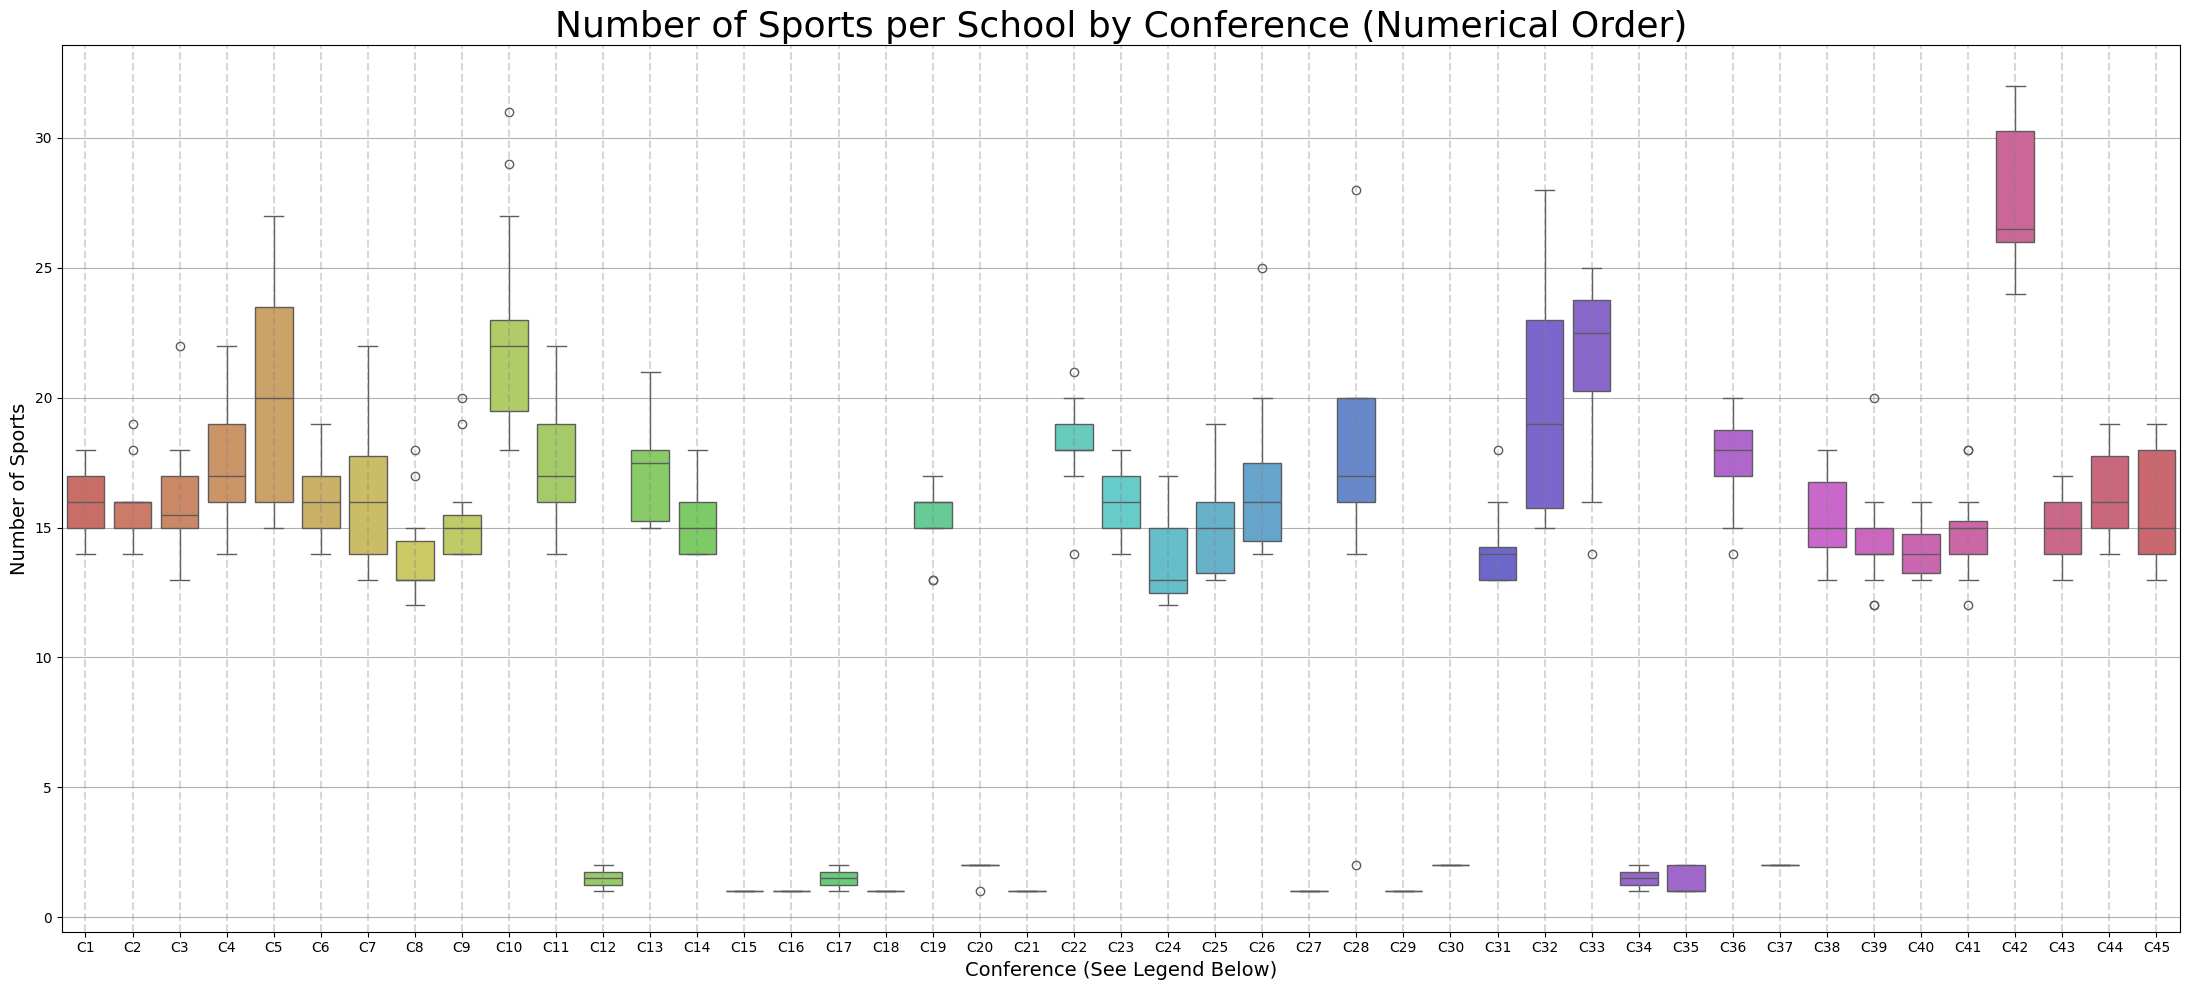

In [69]:
#First step, group the original dataframe by the school ID/name, as well as conference. Then count the number of unique values (sports) are offered at each school using ('SPORT_CODE')
sports_per_school = df.groupby(['SCL_UNITID', 'SCL_NAME', 'CONFNAME_19'])['SPORT_CODE'].nunique().reset_index()

#Next, Rename the count created above ^^ for easy comprehension
sports_per_school.rename(columns={'SPORT_CODE': 'NUM_SPORTS'}, inplace=True)

#Created a sorted list of unique Conf. names, then creaste a mapping from the full conference names --> shorter, easier labels like C1, C2, C3, etc.
unique_confs = sorted(sports_per_school['CONFNAME_19'].unique())
conf_map = {name: f'C{i+1}' for i, name in enumerate(unique_confs)}

#Now add the new column to the dataframe with the confence codes
sports_per_school['CONF_SHORT'] = sports_per_school['CONFNAME_19'].map(conf_map)

#Now I need to extract the numeric part of each shortened code in order to sort the dataframe for the plot
sports_per_school['CONF_SHORT_NUM'] = sports_per_school['CONF_SHORT'].str.extract('(\d+)').astype(int)
sports_per_school_sorted = sports_per_school.sort_values(by='CONF_SHORT_NUM')

# Must define a color palette that ID's a distinct color for each color palette defined by the HLS color palette
palette = sns.color_palette("hls", len(conf_map))

# Figsize 22,10 was the only ratio I found that worked ideally that fit ALL of the data within one scroll-ish
plt.figure(figsize=(22, 10))
#Now creating the boxplot
#   - x is the conference codes we made (C1, C2, C3, etc.)
#   - y is the total number of sports each conference offers
#   - It is in numerical order, and the colors/gridlines are useful for easy distinction between adjacent rows and to understand what plot means what
ax = sns.boxplot(
    data=sports_per_school_sorted,
    x='CONF_SHORT',
    y='NUM_SPORTS',
    order=[f'C{i}' for i in range(1, len(conf_map) + 1)], palette = palette
)

# These two lines set horizontal + vertical grid lines
ax.yaxis.grid(True)
ax.set_axisbelow(True)

#This codes for the vertical gridlines which is easy to read
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', alpha=0.3)


#Set a title, axes labels, and larger fontsizes for readability
plt.title('Number of Sports per School by Conference (Numerical Order)', fontsize=26)
plt.xlabel('Conference (See Legend Below)', fontsize=14)
plt.ylabel('Number of Sports', fontsize=14)

#Learned this in Harp150, it fits the components neatly within the figure size
plt.tight_layout()

In [70]:
# This will print out the legend for comparison, It contains the actual conference names, as well as what C# it corresponds to
print("\n=== Conference Legend ===")
for full_name, short_code in conf_map.items():
    print(f"{short_code}: {full_name}")


=== Conference Legend ===
C1: ASUN Conference
C2: America East Conference
C3: American Athletic Conference
C4: Atlantic 10 Conference
C5: Atlantic Coast Conference
C6: Big 12 Conference
C7: Big East Conference
C8: Big Sky Conference
C9: Big South Conference
C10: Big Ten Conference
C11: Big West Conference
C12: Centennial Conference
C13: Colonial Athletic Association
C14: Conference USA
C15: Great Lakes Intercollegiate Athletic Conference
C16: Great Lakes Valley Conference
C17: Great Northwest Athletic Conference
C18: Gulf South Conference
C19: Horizon League
C20: Liberty League
C21: Lone Star Conference
C22: Metro Atlantic Athletic Conference
C23: Mid-American Conference
C24: Mid-Eastern Athletic Conf.
C25: Missouri Valley Conference
C26: Mountain West Conference
C27: New England Women's and Men's Athletic Conference
C28: Northeast Conference
C29: Northeast-10 Conference
C30: Northern Sun Intercollegiate Conference
C31: Ohio Valley Conference
C32: Pac-12 Conference
C33: Patriot League

Conclusion

To explore this we evaluated the dataset and counted the number of unique sports each conference participated in. From this graph we can see the Ivy Leagues take the lead in sports offered, with about 32 sports for the conference.

The lowest Conference is a shared rank between Great Lakes Intercolegiate, Great Lakes, Gulf South, Lone Star, New England Northeast-10, which are all not main conferences, but instead conferences focused on smaller sports so this makes sense. 

there are a few implications we can derive directly from the visualization
Some conferences such as Atlantic Coast, Big Ten, and Pac-12 have very high total sports offered, meaning these schools have alot more opportunity for students, like we hypothesized
other conferences such as Geat Lakes, Gulf Soutg, and Peach Belt show significantly lower median randes, and even minimums close to 1 or 2 sports, suggesing extremely limited sports opportunites.

The NCAA can use this data to be better informed on which conferences are offering the widest range of oppurtunities for their student athletes and perhaps given more of a priority in the future.

# Conclusion

For our first research question, we found that retention rates for NCAA athleteic teams have steadily improved since 2005. For our second we found that it is possible to accuratley predict APR rates for a given team, and that the most important predictors were a teams retention rate and academic elligibility rate. For our third question we found that private schools have a slightly higher APR, but most importantly public schools lows for APR are much lower then the lows for private schools. Finally, for question four we found that conferences with bigger school tend to sponser more sports

Overall, our analysis was effectivley. We were able to explore the research questions, and come to well supported questions. Due, to constraints in both time and in the dataset our analysis was not as thurough or indepth as it could have been. We could have spent more time looking into confouding variables, and exploring exactly why the data showed the results they did. If the dataset contained more information about the universities, we could have gleamed much deeper information about the teams. For example having the resources avalible for each team, such as schools endowment, athletic budget etc, in the dataset could have allowed for much more indepth analaysis.